In [ ]:
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchvision.utils import save_image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Hyper parameter
latent_size = 64
hidden_size = 256
image_size = 28*28
num_epochs = 100
batch_size = 32
sample_dir = 'samples'

In [ ]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
# Image processing
# transform = transforms.Compose([
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=(.5, .5, .5),
#                                                      std=(.5, .5, .5)),
# ]) # 3 for RGB channels

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[.5],
                                                     std=[.5])
                                ])

In [ ]:
mnist = torchvision.datasets.MNIST(root = '../../data',
                                   train = True,
                                   transform = transform,
                                   download = True,
                                   )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [ ]:
data_loader = torch.utils.data.DataLoader(dataset = mnist,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          )

In [ ]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid(),
)

# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh(),
)

In [ ]:
# Device setting
D = D.to(device)
G = G.to(device)

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def denorm(x):
    out = (x+1)/2
    return out.clamp(0, 1) # torch.clamp == np.clip

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
# Training

total_step = len(data_loader)
train_step = 1
log_interval = 500
for epoch in range(1, num_epochs+1):
    for batch_idx, (images,_) in enumerate(
        tqdm(data_loader, position=0, leave=False, desc='train')
    ):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCELoss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ===============Train The Discriminator===============
        # =====================================================
        
        # Compute BCELoss using real images where BCELoss(x, y) : - y * log(D(x)) - (1-y) * log(1-D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backpropagation and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # =================Train The Generator=================
        # =====================================================

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z))) instead of minimizing log(1-D(z))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backpropagation and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        # Logging
        if train_step%log_interval == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Step [{train_step}/{total_step*num_epochs}]  d_loss : {real_score.mean().item():.4f} g_loss :{fake_score.mean().item()}')
        train_step += 1
    # Save real images
    if epoch == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, f'fake_images-{epoch}.png'))

# Save the model checkpoinfs
torch.save(G.state_dict(), 'G.cpkt')
torch.save(D.state_dict(), 'D.cpkt')

train:  28%|██▊       | 517/1875 [00:04<00:11, 117.23it/s]

Epoch [1/100] Step [500/187500]  d_loss : 0.9949 g_loss :0.014379022642970085


train:  54%|█████▍    | 1014/1875 [00:08<00:07, 114.32it/s]

Epoch [1/100] Step [1000/187500]  d_loss : 0.9961 g_loss :0.03822621703147888


train:  81%|████████  | 1520/1875 [00:13<00:02, 118.59it/s]

Epoch [1/100] Step [1500/187500]  d_loss : 0.9372 g_loss :0.04055142402648926


train:   8%|▊         | 147/1875 [00:01<00:14, 119.02it/s]

Epoch [2/100] Step [2000/187500]  d_loss : 0.8451 g_loss :0.22203528881072998


train:  35%|███▍      | 648/1875 [00:05<00:10, 119.46it/s]

Epoch [2/100] Step [2500/187500]  d_loss : 0.9609 g_loss :0.2583749294281006


train:  61%|██████    | 1139/1875 [00:09<00:06, 115.21it/s]

Epoch [2/100] Step [3000/187500]  d_loss : 0.9399 g_loss :0.22375798225402832


train:  87%|████████▋ | 1640/1875 [00:14<00:02, 116.45it/s]

Epoch [2/100] Step [3500/187500]  d_loss : 0.9846 g_loss :0.0508287250995636


train:  14%|█▍        | 266/1875 [00:02<00:13, 117.01it/s]

Epoch [3/100] Step [4000/187500]  d_loss : 0.9675 g_loss :0.010451601818203926


train:  41%|████      | 762/1875 [00:06<00:09, 114.67it/s]

Epoch [3/100] Step [4500/187500]  d_loss : 0.9648 g_loss :0.0004003613139502704


train:  67%|██████▋   | 1263/1875 [00:10<00:05, 114.99it/s]

Epoch [3/100] Step [5000/187500]  d_loss : 0.9715 g_loss :0.013352109119296074


train:  94%|█████████▍| 1763/1875 [00:15<00:01, 111.07it/s]

Epoch [3/100] Step [5500/187500]  d_loss : 0.9869 g_loss :0.08409862220287323


train:  21%|██        | 391/1875 [00:03<00:13, 114.10it/s]

Epoch [4/100] Step [6000/187500]  d_loss : 0.9986 g_loss :0.11670901626348495


train:  48%|████▊     | 895/1875 [00:07<00:08, 117.89it/s]

Epoch [4/100] Step [6500/187500]  d_loss : 0.9330 g_loss :0.019213102757930756


train:  74%|███████▍  | 1387/1875 [00:11<00:04, 115.99it/s]

Epoch [4/100] Step [7000/187500]  d_loss : 0.8863 g_loss :0.014634590595960617


Epoch [4/100] Step [7500/187500]  d_loss : 0.8638 g_loss :0.05727600306272507


train:  28%|██▊       | 520/1875 [00:04<00:11, 116.91it/s]

Epoch [5/100] Step [8000/187500]  d_loss : 0.9326 g_loss :0.23180034756660461


train:  55%|█████▍    | 1023/1875 [00:08<00:07, 118.90it/s]

Epoch [5/100] Step [8500/187500]  d_loss : 0.7563 g_loss :0.031092725694179535


train:  81%|████████  | 1511/1875 [00:13<00:03, 116.12it/s]

Epoch [5/100] Step [9000/187500]  d_loss : 0.8595 g_loss :0.05168317258358002


train:   8%|▊         | 145/1875 [00:01<00:14, 116.44it/s]

Epoch [6/100] Step [9500/187500]  d_loss : 0.9215 g_loss :0.011749524623155594


train:  35%|███▍      | 647/1875 [00:05<00:10, 114.94it/s]

Epoch [6/100] Step [10000/187500]  d_loss : 0.9310 g_loss :0.03560534864664078


train:  61%|██████    | 1147/1875 [00:09<00:06, 118.19it/s]

Epoch [6/100] Step [10500/187500]  d_loss : 0.9749 g_loss :0.029750637710094452


train:  88%|████████▊ | 1646/1875 [00:14<00:01, 117.70it/s]

Epoch [6/100] Step [11000/187500]  d_loss : 0.9954 g_loss :0.2217968851327896


train:  14%|█▍        | 264/1875 [00:02<00:14, 110.28it/s]

Epoch [7/100] Step [11500/187500]  d_loss : 0.8290 g_loss :0.03791079297661781


train:  41%|████      | 771/1875 [00:06<00:09, 117.31it/s]

Epoch [7/100] Step [12000/187500]  d_loss : 0.9317 g_loss :0.03103051148355007


train:  68%|██████▊   | 1273/1875 [00:10<00:05, 117.28it/s]

Epoch [7/100] Step [12500/187500]  d_loss : 0.8559 g_loss :0.011686794459819794


train:  94%|█████████▍| 1766/1875 [00:15<00:00, 119.00it/s]

Epoch [7/100] Step [13000/187500]  d_loss : 0.8780 g_loss :0.011962560936808586


train:  21%|██        | 389/1875 [00:03<00:12, 114.76it/s]

Epoch [8/100] Step [13500/187500]  d_loss : 0.9175 g_loss :0.032975517213344574


train:  48%|████▊     | 893/1875 [00:07<00:08, 116.39it/s]

Epoch [8/100] Step [14000/187500]  d_loss : 0.7093 g_loss :0.0070524998009204865


train:  74%|███████▍  | 1390/1875 [00:12<00:04, 115.64it/s]

Epoch [8/100] Step [14500/187500]  d_loss : 0.9313 g_loss :0.212326318025589


Epoch [8/100] Step [15000/187500]  d_loss : 0.7642 g_loss :0.036595217883586884


train:  28%|██▊       | 524/1875 [00:04<00:11, 117.60it/s]

Epoch [9/100] Step [15500/187500]  d_loss : 0.9601 g_loss :0.3186315894126892


train:  54%|█████▍    | 1012/1875 [00:08<00:07, 117.79it/s]

Epoch [9/100] Step [16000/187500]  d_loss : 0.7640 g_loss :0.027167007327079773


train:  81%|████████  | 1512/1875 [00:13<00:03, 116.41it/s]

Epoch [9/100] Step [16500/187500]  d_loss : 0.8708 g_loss :0.0707002729177475


train:   8%|▊         | 145/1875 [00:01<00:14, 115.39it/s]

Epoch [10/100] Step [17000/187500]  d_loss : 0.8601 g_loss :0.18916158378124237


train:  34%|███▍      | 639/1875 [00:05<00:10, 113.30it/s]

Epoch [10/100] Step [17500/187500]  d_loss : 0.8984 g_loss :0.12045247107744217


train:  61%|██████    | 1143/1875 [00:09<00:06, 115.15it/s]

Epoch [10/100] Step [18000/187500]  d_loss : 0.8966 g_loss :0.1374475359916687


train:  88%|████████▊ | 1645/1875 [00:14<00:02, 113.68it/s]

Epoch [10/100] Step [18500/187500]  d_loss : 0.9147 g_loss :0.12026562541723251


train:  14%|█▍        | 269/1875 [00:02<00:14, 113.75it/s]

Epoch [11/100] Step [19000/187500]  d_loss : 0.9377 g_loss :0.07979501783847809


train:  41%|████      | 771/1875 [00:06<00:09, 115.66it/s]

Epoch [11/100] Step [19500/187500]  d_loss : 0.8498 g_loss :0.07713153958320618


train:  68%|██████▊   | 1270/1875 [00:10<00:05, 117.55it/s]

Epoch [11/100] Step [20000/187500]  d_loss : 0.9496 g_loss :0.249093696475029


train:  95%|█████████▍| 1772/1875 [00:15<00:00, 117.24it/s]

Epoch [11/100] Step [20500/187500]  d_loss : 0.8714 g_loss :0.16967153549194336


train:  21%|██        | 390/1875 [00:03<00:12, 117.19it/s]

Epoch [12/100] Step [21000/187500]  d_loss : 0.9480 g_loss :0.1466446816921234


train:  48%|████▊     | 896/1875 [00:07<00:08, 115.53it/s]

Epoch [12/100] Step [21500/187500]  d_loss : 0.8706 g_loss :0.11330596357584


train:  74%|███████▍  | 1387/1875 [00:12<00:04, 114.64it/s]

Epoch [12/100] Step [22000/187500]  d_loss : 0.8784 g_loss :0.27883681654930115


Epoch [12/100] Step [22500/187500]  d_loss : 0.8420 g_loss :0.2435043454170227


train:  28%|██▊       | 522/1875 [00:04<00:11, 116.83it/s]

Epoch [13/100] Step [23000/187500]  d_loss : 0.7613 g_loss :0.08028024435043335


train:  54%|█████▍    | 1021/1875 [00:08<00:07, 112.49it/s]

Epoch [13/100] Step [23500/187500]  d_loss : 0.7394 g_loss :0.06314431875944138


train:  81%|████████  | 1521/1875 [00:13<00:03, 112.44it/s]

Epoch [13/100] Step [24000/187500]  d_loss : 0.8036 g_loss :0.09531610459089279


train:   8%|▊         | 145/1875 [00:01<00:14, 116.06it/s]

Epoch [14/100] Step [24500/187500]  d_loss : 0.8979 g_loss :0.09619886428117752


train:  34%|███▍      | 640/1875 [00:05<00:10, 112.32it/s]

Epoch [14/100] Step [25000/187500]  d_loss : 0.9226 g_loss :0.27888455986976624


train:  61%|██████    | 1137/1875 [00:09<00:06, 116.90it/s]

Epoch [14/100] Step [25500/187500]  d_loss : 0.9343 g_loss :0.22817817330360413


train:  88%|████████▊ | 1647/1875 [00:14<00:01, 117.42it/s]

Epoch [14/100] Step [26000/187500]  d_loss : 0.7878 g_loss :0.09173008054494858


train:  14%|█▍        | 268/1875 [00:02<00:13, 116.94it/s]

Epoch [15/100] Step [26500/187500]  d_loss : 0.7424 g_loss :0.0962287038564682


train:  41%|████      | 765/1875 [00:06<00:09, 116.07it/s]

Epoch [15/100] Step [27000/187500]  d_loss : 0.7207 g_loss :0.09878624230623245


train:  67%|██████▋   | 1263/1875 [00:10<00:05, 117.13it/s]

Epoch [15/100] Step [27500/187500]  d_loss : 0.8754 g_loss :0.1837802231311798


train:  94%|█████████▍| 1766/1875 [00:15<00:00, 118.23it/s]

Epoch [15/100] Step [28000/187500]  d_loss : 0.7878 g_loss :0.19445301592350006


train:  21%|██        | 388/1875 [00:03<00:12, 116.53it/s]

Epoch [16/100] Step [28500/187500]  d_loss : 0.8148 g_loss :0.10736406594514847


train:  47%|████▋     | 887/1875 [00:07<00:08, 115.98it/s]

Epoch [16/100] Step [29000/187500]  d_loss : 0.7695 g_loss :0.11470910906791687


train:  74%|███████▍  | 1388/1875 [00:11<00:04, 113.99it/s]

Epoch [16/100] Step [29500/187500]  d_loss : 0.6973 g_loss :0.15200380980968475


Epoch [16/100] Step [30000/187500]  d_loss : 0.8004 g_loss :0.20439685881137848


train:  28%|██▊       | 519/1875 [00:04<00:12, 110.28it/s]

Epoch [17/100] Step [30500/187500]  d_loss : 0.7878 g_loss :0.12418152391910553


train:  54%|█████▍    | 1014/1875 [00:08<00:07, 112.83it/s]

Epoch [17/100] Step [31000/187500]  d_loss : 0.8278 g_loss :0.09904426336288452


train:  81%|████████  | 1519/1875 [00:13<00:03, 111.08it/s]

Epoch [17/100] Step [31500/187500]  d_loss : 0.7661 g_loss :0.12210957705974579


train:   8%|▊         | 144/1875 [00:01<00:15, 114.84it/s]

Epoch [18/100] Step [32000/187500]  d_loss : 0.7687 g_loss :0.11747260391712189


train:  34%|███▍      | 643/1875 [00:05<00:10, 115.24it/s]

Epoch [18/100] Step [32500/187500]  d_loss : 0.8293 g_loss :0.16669458150863647


train:  61%|██████    | 1144/1875 [00:09<00:06, 114.82it/s]

Epoch [18/100] Step [33000/187500]  d_loss : 0.7956 g_loss :0.16451311111450195


train:  88%|████████▊ | 1646/1875 [00:14<00:01, 116.22it/s]

Epoch [18/100] Step [33500/187500]  d_loss : 0.7577 g_loss :0.21718814969062805


train:  15%|█▍        | 272/1875 [00:02<00:13, 115.63it/s]

Epoch [19/100] Step [34000/187500]  d_loss : 0.7760 g_loss :0.15137998759746552


train:  41%|████      | 764/1875 [00:06<00:09, 115.47it/s]

Epoch [19/100] Step [34500/187500]  d_loss : 0.8671 g_loss :0.4261646568775177


train:  68%|██████▊   | 1267/1875 [00:10<00:05, 117.28it/s]

Epoch [19/100] Step [35000/187500]  d_loss : 0.7618 g_loss :0.12232355028390884


train:  94%|█████████▍| 1771/1875 [00:15<00:00, 115.31it/s]

Epoch [19/100] Step [35500/187500]  d_loss : 0.7371 g_loss :0.19107899069786072


train:  21%|██        | 388/1875 [00:03<00:12, 115.37it/s]

Epoch [20/100] Step [36000/187500]  d_loss : 0.7849 g_loss :0.2013358771800995


train:  48%|████▊     | 897/1875 [00:07<00:08, 111.48it/s]

Epoch [20/100] Step [36500/187500]  d_loss : 0.8413 g_loss :0.25338929891586304


train:  74%|███████▍  | 1394/1875 [00:12<00:04, 116.24it/s]

Epoch [20/100] Step [37000/187500]  d_loss : 0.7856 g_loss :0.3352756202220917


Epoch [20/100] Step [37500/187500]  d_loss : 0.8698 g_loss :0.22726136445999146


train:  27%|██▋       | 514/1875 [00:04<00:11, 114.70it/s]

Epoch [21/100] Step [38000/187500]  d_loss : 0.7585 g_loss :0.19901038706302643


train:  55%|█████▍    | 1022/1875 [00:08<00:07, 115.39it/s]

Epoch [21/100] Step [38500/187500]  d_loss : 0.8137 g_loss :0.1206587478518486


train:  81%|████████  | 1521/1875 [00:13<00:03, 116.77it/s]

Epoch [21/100] Step [39000/187500]  d_loss : 0.8895 g_loss :0.11928735673427582


train:   8%|▊         | 147/1875 [00:01<00:14, 117.09it/s]

Epoch [22/100] Step [39500/187500]  d_loss : 0.9578 g_loss :0.1958838403224945


train:  34%|███▍      | 637/1875 [00:05<00:10, 117.69it/s]

Epoch [22/100] Step [40000/187500]  d_loss : 0.8083 g_loss :0.06082172319293022


train:  61%|██████    | 1138/1875 [00:09<00:06, 114.02it/s]

Epoch [22/100] Step [40500/187500]  d_loss : 0.9034 g_loss :0.16353189945220947


train:  88%|████████▊ | 1647/1875 [00:14<00:01, 115.22it/s]

Epoch [22/100] Step [41000/187500]  d_loss : 0.7532 g_loss :0.13112926483154297


train:  14%|█▍        | 268/1875 [00:02<00:13, 116.06it/s]

Epoch [23/100] Step [41500/187500]  d_loss : 0.7012 g_loss :0.1611705869436264


train:  41%|████      | 764/1875 [00:06<00:09, 113.50it/s]

Epoch [23/100] Step [42000/187500]  d_loss : 0.7155 g_loss :0.1634225845336914


train:  67%|██████▋   | 1264/1875 [00:10<00:05, 114.29it/s]

Epoch [23/100] Step [42500/187500]  d_loss : 0.7697 g_loss :0.2895497679710388


train:  94%|█████████▍| 1765/1875 [00:15<00:00, 115.94it/s]

Epoch [23/100] Step [43000/187500]  d_loss : 0.8051 g_loss :0.24220982193946838


train:  21%|██        | 396/1875 [00:03<00:12, 118.14it/s]

Epoch [24/100] Step [43500/187500]  d_loss : 0.7029 g_loss :0.27310872077941895


train:  48%|████▊     | 895/1875 [00:07<00:08, 117.47it/s]

Epoch [24/100] Step [44000/187500]  d_loss : 0.7118 g_loss :0.1777326762676239


train:  74%|███████▍  | 1395/1875 [00:12<00:04, 112.84it/s]

Epoch [24/100] Step [44500/187500]  d_loss : 0.6961 g_loss :0.33901360630989075


Epoch [24/100] Step [45000/187500]  d_loss : 0.8102 g_loss :0.2164728343486786


train:  28%|██▊       | 518/1875 [00:04<00:11, 117.34it/s]

Epoch [25/100] Step [45500/187500]  d_loss : 0.7415 g_loss :0.4128837287425995


train:  54%|█████▍    | 1015/1875 [00:08<00:07, 112.44it/s]

Epoch [25/100] Step [46000/187500]  d_loss : 0.7526 g_loss :0.24088673293590546


train:  81%|████████  | 1513/1875 [00:13<00:03, 115.09it/s]

Epoch [25/100] Step [46500/187500]  d_loss : 0.8761 g_loss :0.2936440706253052


train:   8%|▊         | 145/1875 [00:01<00:15, 114.97it/s]

Epoch [26/100] Step [47000/187500]  d_loss : 0.5748 g_loss :0.22930142283439636


train:  34%|███▍      | 644/1875 [00:05<00:10, 115.72it/s]

Epoch [26/100] Step [47500/187500]  d_loss : 0.9233 g_loss :0.3402649760246277


train:  61%|██████    | 1144/1875 [00:09<00:06, 112.69it/s]

Epoch [26/100] Step [48000/187500]  d_loss : 0.7150 g_loss :0.10821107029914856


train:  88%|████████▊ | 1645/1875 [00:14<00:02, 114.48it/s]

Epoch [26/100] Step [48500/187500]  d_loss : 0.9077 g_loss :0.37670427560806274


train:  14%|█▍        | 268/1875 [00:02<00:13, 117.24it/s]

Epoch [27/100] Step [49000/187500]  d_loss : 0.8328 g_loss :0.2263692021369934


train:  41%|████      | 766/1875 [00:06<00:09, 111.28it/s]

Epoch [27/100] Step [49500/187500]  d_loss : 0.7398 g_loss :0.22365695238113403


train:  68%|██████▊   | 1268/1875 [00:10<00:05, 118.38it/s]

Epoch [27/100] Step [50000/187500]  d_loss : 0.8480 g_loss :0.3232983648777008


train:  94%|█████████▍| 1767/1875 [00:15<00:00, 116.72it/s]

Epoch [27/100] Step [50500/187500]  d_loss : 0.8196 g_loss :0.19801658391952515


train:  21%|██        | 389/1875 [00:03<00:12, 115.92it/s]

Epoch [28/100] Step [51000/187500]  d_loss : 0.7665 g_loss :0.29929405450820923


train:  48%|████▊     | 897/1875 [00:07<00:08, 116.63it/s]

Epoch [28/100] Step [51500/187500]  d_loss : 0.6811 g_loss :0.2233867049217224


train:  74%|███████▍  | 1392/1875 [00:12<00:04, 115.30it/s]

Epoch [28/100] Step [52000/187500]  d_loss : 0.7799 g_loss :0.512602686882019


Epoch [28/100] Step [52500/187500]  d_loss : 0.8430 g_loss :0.30434542894363403


train:  28%|██▊       | 521/1875 [00:04<00:11, 115.65it/s]

Epoch [29/100] Step [53000/187500]  d_loss : 0.7953 g_loss :0.3954259157180786


train:  54%|█████▍    | 1013/1875 [00:08<00:07, 114.82it/s]

Epoch [29/100] Step [53500/187500]  d_loss : 0.6669 g_loss :0.25573813915252686


train:  81%|████████  | 1517/1875 [00:13<00:03, 114.60it/s]

Epoch [29/100] Step [54000/187500]  d_loss : 0.8139 g_loss :0.373728483915329


train:   8%|▊         | 144/1875 [00:01<00:15, 114.22it/s]

Epoch [30/100] Step [54500/187500]  d_loss : 0.8084 g_loss :0.2971153259277344


train:  34%|███▍      | 640/1875 [00:05<00:10, 118.04it/s]

Epoch [30/100] Step [55000/187500]  d_loss : 0.7676 g_loss :0.2223283052444458


train:  61%|██████    | 1141/1875 [00:09<00:06, 115.63it/s]

Epoch [30/100] Step [55500/187500]  d_loss : 0.7384 g_loss :0.20712614059448242


train:  88%|████████▊ | 1647/1875 [00:14<00:01, 115.49it/s]

Epoch [30/100] Step [56000/187500]  d_loss : 0.7566 g_loss :0.28961843252182007


train:  14%|█▍        | 267/1875 [00:02<00:13, 116.01it/s]

Epoch [31/100] Step [56500/187500]  d_loss : 0.7169 g_loss :0.31843996047973633


train:  41%|████      | 769/1875 [00:06<00:09, 114.03it/s]

Epoch [31/100] Step [57000/187500]  d_loss : 0.7256 g_loss :0.33655840158462524


train:  68%|██████▊   | 1272/1875 [00:10<00:05, 117.90it/s]

Epoch [31/100] Step [57500/187500]  d_loss : 0.7675 g_loss :0.2924198508262634


train:  94%|█████████▍| 1768/1875 [00:15<00:00, 115.42it/s]

Epoch [31/100] Step [58000/187500]  d_loss : 0.6429 g_loss :0.2581232488155365


train:  21%|██        | 387/1875 [00:03<00:12, 116.31it/s]

Epoch [32/100] Step [58500/187500]  d_loss : 0.8295 g_loss :0.24121373891830444


train:  48%|████▊     | 894/1875 [00:07<00:08, 117.00it/s]

Epoch [32/100] Step [59000/187500]  d_loss : 0.8213 g_loss :0.2593010365962982


train:  75%|███████▍  | 1397/1875 [00:12<00:04, 113.05it/s]

Epoch [32/100] Step [59500/187500]  d_loss : 0.6415 g_loss :0.13175994157791138


Epoch [32/100] Step [60000/187500]  d_loss : 0.7466 g_loss :0.265657901763916


train:  28%|██▊       | 517/1875 [00:04<00:11, 114.63it/s]

Epoch [33/100] Step [60500/187500]  d_loss : 0.7150 g_loss :0.3347335159778595


train:  55%|█████▍    | 1022/1875 [00:08<00:07, 117.16it/s]

Epoch [33/100] Step [61000/187500]  d_loss : 0.8499 g_loss :0.3390215337276459


train:  81%|████████  | 1517/1875 [00:13<00:03, 114.09it/s]

Epoch [33/100] Step [61500/187500]  d_loss : 0.7802 g_loss :0.31020307540893555


train:   8%|▊         | 143/1875 [00:01<00:14, 116.07it/s]

Epoch [34/100] Step [62000/187500]  d_loss : 0.6866 g_loss :0.3787396550178528


train:  34%|███▍      | 645/1875 [00:05<00:10, 115.44it/s]

Epoch [34/100] Step [62500/187500]  d_loss : 0.7086 g_loss :0.30148011445999146


train:  61%|██████    | 1137/1875 [00:10<00:06, 113.07it/s]

Epoch [34/100] Step [63000/187500]  d_loss : 0.6457 g_loss :0.27833831310272217


train:  87%|████████▋ | 1639/1875 [00:14<00:02, 115.16it/s]

Epoch [34/100] Step [63500/187500]  d_loss : 0.7954 g_loss :0.3613910675048828


train:  14%|█▍        | 264/1875 [00:02<00:14, 114.27it/s]

Epoch [35/100] Step [64000/187500]  d_loss : 0.6259 g_loss :0.23388874530792236


train:  41%|████      | 771/1875 [00:06<00:09, 114.55it/s]

Epoch [35/100] Step [64500/187500]  d_loss : 0.8370 g_loss :0.30526548624038696


train:  68%|██████▊   | 1269/1875 [00:11<00:05, 116.82it/s]

Epoch [35/100] Step [65000/187500]  d_loss : 0.7719 g_loss :0.3384895324707031


train:  94%|█████████▍| 1763/1875 [00:15<00:00, 115.28it/s]

Epoch [35/100] Step [65500/187500]  d_loss : 0.7163 g_loss :0.3951663374900818


train:  21%|██        | 398/1875 [00:03<00:12, 116.30it/s]

Epoch [36/100] Step [66000/187500]  d_loss : 0.8026 g_loss :0.2559998333454132


train:  48%|████▊     | 895/1875 [00:07<00:08, 114.49it/s]

Epoch [36/100] Step [66500/187500]  d_loss : 0.7146 g_loss :0.3488966226577759


train:  74%|███████▍  | 1390/1875 [00:12<00:04, 107.54it/s]

Epoch [36/100] Step [67000/187500]  d_loss : 0.7574 g_loss :0.21086180210113525


Epoch [36/100] Step [67500/187500]  d_loss : 0.7219 g_loss :0.30259716510772705


train:  27%|██▋       | 513/1875 [00:04<00:12, 113.02it/s]

Epoch [37/100] Step [68000/187500]  d_loss : 0.7232 g_loss :0.21025685966014862


train:  54%|█████▍    | 1019/1875 [00:08<00:07, 116.06it/s]

Epoch [37/100] Step [68500/187500]  d_loss : 0.8030 g_loss :0.3864293694496155


train:  81%|████████  | 1514/1875 [00:13<00:03, 116.64it/s]

Epoch [37/100] Step [69000/187500]  d_loss : 0.7919 g_loss :0.33910655975341797


train:   8%|▊         | 144/1875 [00:01<00:14, 116.24it/s]

Epoch [38/100] Step [69500/187500]  d_loss : 0.7156 g_loss :0.23102283477783203


train:  34%|███▍      | 637/1875 [00:05<00:10, 114.54it/s]

Epoch [38/100] Step [70000/187500]  d_loss : 0.6769 g_loss :0.2167477160692215


train:  61%|██████    | 1142/1875 [00:09<00:06, 111.38it/s]

Epoch [38/100] Step [70500/187500]  d_loss : 0.6666 g_loss :0.30258405208587646


train:  88%|████████▊ | 1646/1875 [00:14<00:02, 114.42it/s]

Epoch [38/100] Step [71000/187500]  d_loss : 0.6476 g_loss :0.19073453545570374


train:  14%|█▍        | 264/1875 [00:02<00:13, 115.66it/s]

Epoch [39/100] Step [71500/187500]  d_loss : 0.7058 g_loss :0.36530399322509766


train:  41%|████      | 770/1875 [00:06<00:09, 115.96it/s]

Epoch [39/100] Step [72000/187500]  d_loss : 0.7210 g_loss :0.26678165793418884


train:  67%|██████▋   | 1262/1875 [00:11<00:05, 113.99it/s]

Epoch [39/100] Step [72500/187500]  d_loss : 0.7047 g_loss :0.22927019000053406


train:  94%|█████████▍| 1766/1875 [00:15<00:00, 113.28it/s]

Epoch [39/100] Step [73000/187500]  d_loss : 0.7680 g_loss :0.3622877597808838


train:  21%|██        | 395/1875 [00:03<00:13, 112.50it/s]

Epoch [40/100] Step [73500/187500]  d_loss : 0.7630 g_loss :0.3926237225532532


train:  47%|████▋     | 888/1875 [00:07<00:08, 111.37it/s]

Epoch [40/100] Step [74000/187500]  d_loss : 0.7647 g_loss :0.30928871035575867


train:  74%|███████▍  | 1390/1875 [00:12<00:04, 109.62it/s]

Epoch [40/100] Step [74500/187500]  d_loss : 0.7608 g_loss :0.2708285450935364


Epoch [40/100] Step [75000/187500]  d_loss : 0.7636 g_loss :0.3548407554626465


train:  28%|██▊       | 517/1875 [00:04<00:11, 114.62it/s]

Epoch [41/100] Step [75500/187500]  d_loss : 0.5696 g_loss :0.27852270007133484


train:  54%|█████▍    | 1021/1875 [00:08<00:07, 112.03it/s]

Epoch [41/100] Step [76000/187500]  d_loss : 0.7667 g_loss :0.39697006344795227


train:  81%|████████  | 1513/1875 [00:13<00:03, 116.05it/s]

Epoch [41/100] Step [76500/187500]  d_loss : 0.7430 g_loss :0.28149715065956116


train:   8%|▊         | 142/1875 [00:01<00:15, 111.17it/s]

Epoch [42/100] Step [77000/187500]  d_loss : 0.6324 g_loss :0.2653735876083374


train:  34%|███▍      | 637/1875 [00:05<00:10, 116.52it/s]

Epoch [42/100] Step [77500/187500]  d_loss : 0.6208 g_loss :0.2761473059654236


train:  61%|██████    | 1141/1875 [00:10<00:06, 114.59it/s]

Epoch [42/100] Step [78000/187500]  d_loss : 0.6193 g_loss :0.33360186219215393


train:  88%|████████▊ | 1642/1875 [00:14<00:02, 112.92it/s]

Epoch [42/100] Step [78500/187500]  d_loss : 0.6859 g_loss :0.3126797676086426


train:  14%|█▍        | 264/1875 [00:02<00:14, 114.03it/s]

Epoch [43/100] Step [79000/187500]  d_loss : 0.5647 g_loss :0.20590518414974213


train:  41%|████      | 768/1875 [00:06<00:09, 112.16it/s]

Epoch [43/100] Step [79500/187500]  d_loss : 0.7258 g_loss :0.3322470188140869


train:  67%|██████▋   | 1262/1875 [00:11<00:05, 114.77it/s]

Epoch [43/100] Step [80000/187500]  d_loss : 0.7705 g_loss :0.327479749917984


train:  94%|█████████▍| 1766/1875 [00:15<00:00, 114.82it/s]

Epoch [43/100] Step [80500/187500]  d_loss : 0.6899 g_loss :0.2532523572444916


train:  21%|██        | 389/1875 [00:03<00:13, 110.59it/s]

Epoch [44/100] Step [81000/187500]  d_loss : 0.7866 g_loss :0.3366532325744629


train:  48%|████▊     | 894/1875 [00:07<00:08, 114.03it/s]

Epoch [44/100] Step [81500/187500]  d_loss : 0.7725 g_loss :0.20030923187732697


train:  75%|███████▍  | 1397/1875 [00:12<00:04, 112.19it/s]

Epoch [44/100] Step [82000/187500]  d_loss : 0.7876 g_loss :0.4215862452983856


Epoch [44/100] Step [82500/187500]  d_loss : 0.5981 g_loss :0.25443971157073975


train:  28%|██▊       | 516/1875 [00:04<00:12, 112.98it/s]

Epoch [45/100] Step [83000/187500]  d_loss : 0.7295 g_loss :0.3637063503265381


train:  54%|█████▍    | 1020/1875 [00:09<00:07, 112.46it/s]

Epoch [45/100] Step [83500/187500]  d_loss : 0.7638 g_loss :0.23199763894081116


train:  81%|████████  | 1512/1875 [00:13<00:03, 114.49it/s]

Epoch [45/100] Step [84000/187500]  d_loss : 0.5850 g_loss :0.3440955579280853


train:   8%|▊         | 144/1875 [00:01<00:15, 112.54it/s]

Epoch [46/100] Step [84500/187500]  d_loss : 0.6420 g_loss :0.30462536215782166


train:  34%|███▍      | 636/1875 [00:05<00:11, 111.51it/s]

Epoch [46/100] Step [85000/187500]  d_loss : 0.7593 g_loss :0.3484417200088501


train:  61%|██████    | 1141/1875 [00:10<00:06, 115.03it/s]

Epoch [46/100] Step [85500/187500]  d_loss : 0.7080 g_loss :0.3343965411186218


train:  88%|████████▊ | 1642/1875 [00:14<00:02, 113.05it/s]

Epoch [46/100] Step [86000/187500]  d_loss : 0.7839 g_loss :0.16597400605678558


train:  14%|█▍        | 271/1875 [00:02<00:14, 109.69it/s]

Epoch [47/100] Step [86500/187500]  d_loss : 0.7200 g_loss :0.32580605149269104


train:  41%|████      | 763/1875 [00:06<00:09, 114.10it/s]

Epoch [47/100] Step [87000/187500]  d_loss : 0.7250 g_loss :0.33698177337646484


train:  68%|██████▊   | 1267/1875 [00:11<00:05, 109.68it/s]

Epoch [47/100] Step [87500/187500]  d_loss : 0.6111 g_loss :0.30627012252807617


train:  94%|█████████▍| 1771/1875 [00:15<00:00, 114.51it/s]

Epoch [47/100] Step [88000/187500]  d_loss : 0.6734 g_loss :0.3502125144004822


train:  21%|██        | 398/1875 [00:03<00:12, 114.72it/s]

Epoch [48/100] Step [88500/187500]  d_loss : 0.7449 g_loss :0.2664506435394287


train:  48%|████▊     | 897/1875 [00:07<00:08, 112.22it/s]

Epoch [48/100] Step [89000/187500]  d_loss : 0.8046 g_loss :0.31415146589279175


train:  74%|███████▍  | 1389/1875 [00:12<00:04, 113.00it/s]

Epoch [48/100] Step [89500/187500]  d_loss : 0.6075 g_loss :0.27483606338500977


Epoch [48/100] Step [90000/187500]  d_loss : 0.7046 g_loss :0.4041726589202881


train:  28%|██▊       | 517/1875 [00:04<00:12, 111.10it/s]

Epoch [49/100] Step [90500/187500]  d_loss : 0.7677 g_loss :0.354728639125824


train:  54%|█████▍    | 1021/1875 [00:08<00:07, 114.35it/s]

Epoch [49/100] Step [91000/187500]  d_loss : 0.7642 g_loss :0.41656309366226196


train:  81%|████████  | 1513/1875 [00:13<00:03, 115.19it/s]

Epoch [49/100] Step [91500/187500]  d_loss : 0.7436 g_loss :0.24607504904270172


train:   8%|▊         | 142/1875 [00:01<00:15, 115.10it/s]

Epoch [50/100] Step [92000/187500]  d_loss : 0.5757 g_loss :0.3623405694961548


train:  35%|███▍      | 647/1875 [00:05<00:10, 114.01it/s]

Epoch [50/100] Step [92500/187500]  d_loss : 0.6703 g_loss :0.2702808976173401


train:  61%|██████    | 1138/1875 [00:10<00:06, 112.13it/s]

Epoch [50/100] Step [93000/187500]  d_loss : 0.7991 g_loss :0.4906994104385376


train:  88%|████████▊ | 1641/1875 [00:14<00:02, 114.08it/s]

Epoch [50/100] Step [93500/187500]  d_loss : 0.7609 g_loss :0.379642516374588


train:  14%|█▍        | 265/1875 [00:02<00:13, 116.13it/s]

Epoch [51/100] Step [94000/187500]  d_loss : 0.6706 g_loss :0.32215970754623413


train:  41%|████      | 772/1875 [00:06<00:09, 112.79it/s]

Epoch [51/100] Step [94500/187500]  d_loss : 0.6130 g_loss :0.2732745110988617


train:  68%|██████▊   | 1267/1875 [00:11<00:05, 114.92it/s]

Epoch [51/100] Step [95000/187500]  d_loss : 0.6124 g_loss :0.30259865522384644


train:  94%|█████████▍| 1770/1875 [00:15<00:00, 113.57it/s]

Epoch [51/100] Step [95500/187500]  d_loss : 0.6359 g_loss :0.2621208131313324


train:  21%|██        | 397/1875 [00:03<00:12, 114.69it/s]

Epoch [52/100] Step [96000/187500]  d_loss : 0.7320 g_loss :0.37808313965797424


train:  47%|████▋     | 890/1875 [00:07<00:08, 112.01it/s]

Epoch [52/100] Step [96500/187500]  d_loss : 0.8001 g_loss :0.37211573123931885


train:  74%|███████▍  | 1391/1875 [00:12<00:04, 111.04it/s]

Epoch [52/100] Step [97000/187500]  d_loss : 0.7418 g_loss :0.3210626244544983


Epoch [52/100] Step [97500/187500]  d_loss : 0.6940 g_loss :0.2451130747795105


train:  28%|██▊       | 519/1875 [00:04<00:12, 112.93it/s]

Epoch [53/100] Step [98000/187500]  d_loss : 0.6707 g_loss :0.2857884466648102


train:  54%|█████▍    | 1014/1875 [00:08<00:07, 112.11it/s]

Epoch [53/100] Step [98500/187500]  d_loss : 0.7159 g_loss :0.2591501474380493


train:  81%|████████  | 1521/1875 [00:13<00:03, 117.22it/s]

Epoch [53/100] Step [99000/187500]  d_loss : 0.6824 g_loss :0.2779468297958374


train:   8%|▊         | 144/1875 [00:01<00:14, 115.49it/s]

Epoch [54/100] Step [99500/187500]  d_loss : 0.6645 g_loss :0.2561315596103668


train:  35%|███▍      | 648/1875 [00:05<00:10, 112.96it/s]

Epoch [54/100] Step [100000/187500]  d_loss : 0.6191 g_loss :0.2335047870874405


train:  61%|██████    | 1140/1875 [00:10<00:06, 109.61it/s]

Epoch [54/100] Step [100500/187500]  d_loss : 0.6701 g_loss :0.30475789308547974


train:  88%|████████▊ | 1648/1875 [00:14<00:02, 112.18it/s]

Epoch [54/100] Step [101000/187500]  d_loss : 0.7520 g_loss :0.3602735996246338


train:  14%|█▍        | 264/1875 [00:02<00:14, 114.36it/s]

Epoch [55/100] Step [101500/187500]  d_loss : 0.7750 g_loss :0.4361131191253662


train:  41%|████      | 769/1875 [00:06<00:10, 110.59it/s]

Epoch [55/100] Step [102000/187500]  d_loss : 0.7045 g_loss :0.33623695373535156


train:  68%|██████▊   | 1273/1875 [00:11<00:05, 113.80it/s]

Epoch [55/100] Step [102500/187500]  d_loss : 0.6093 g_loss :0.2550619840621948


train:  94%|█████████▍| 1764/1875 [00:15<00:00, 114.68it/s]

Epoch [55/100] Step [103000/187500]  d_loss : 0.6157 g_loss :0.2700026035308838


train:  21%|██        | 394/1875 [00:03<00:13, 110.92it/s]

Epoch [56/100] Step [103500/187500]  d_loss : 0.7235 g_loss :0.27464979887008667


train:  47%|████▋     | 889/1875 [00:07<00:09, 106.54it/s]

Epoch [56/100] Step [104000/187500]  d_loss : 0.6863 g_loss :0.4199657440185547


train:  74%|███████▍  | 1392/1875 [00:12<00:04, 115.84it/s]

Epoch [56/100] Step [104500/187500]  d_loss : 0.7888 g_loss :0.43532660603523254


Epoch [56/100] Step [105000/187500]  d_loss : 0.6528 g_loss :0.36356768012046814


train:  28%|██▊       | 518/1875 [00:04<00:11, 114.34it/s]

Epoch [57/100] Step [105500/187500]  d_loss : 0.6852 g_loss :0.21842867136001587


train:  55%|█████▍    | 1023/1875 [00:08<00:07, 115.55it/s]

Epoch [57/100] Step [106000/187500]  d_loss : 0.5540 g_loss :0.2850361466407776


train:  81%|████████  | 1518/1875 [00:13<00:03, 113.80it/s]

Epoch [57/100] Step [106500/187500]  d_loss : 0.7246 g_loss :0.3567954897880554


train:   8%|▊         | 143/1875 [00:01<00:15, 113.19it/s]

Epoch [58/100] Step [107000/187500]  d_loss : 0.7082 g_loss :0.3190380930900574


train:  34%|███▍      | 638/1875 [00:05<00:11, 111.99it/s]

Epoch [58/100] Step [107500/187500]  d_loss : 0.6763 g_loss :0.33970165252685547


train:  61%|██████    | 1141/1875 [00:10<00:06, 106.03it/s]

Epoch [58/100] Step [108000/187500]  d_loss : 0.7676 g_loss :0.2619309425354004


train:  88%|████████▊ | 1647/1875 [00:14<00:01, 114.90it/s]

Epoch [58/100] Step [108500/187500]  d_loss : 0.7318 g_loss :0.36712464690208435


train:  14%|█▍        | 264/1875 [00:02<00:14, 114.70it/s]

Epoch [59/100] Step [109000/187500]  d_loss : 0.7942 g_loss :0.27961134910583496


train:  41%|████      | 768/1875 [00:06<00:09, 112.39it/s]

Epoch [59/100] Step [109500/187500]  d_loss : 0.6425 g_loss :0.28820669651031494


train:  68%|██████▊   | 1272/1875 [00:11<00:05, 115.11it/s]

Epoch [59/100] Step [110000/187500]  d_loss : 0.7384 g_loss :0.340810626745224


train:  94%|█████████▍| 1765/1875 [00:15<00:00, 113.33it/s]

Epoch [59/100] Step [110500/187500]  d_loss : 0.8047 g_loss :0.4984655976295471


train:  21%|██        | 387/1875 [00:03<00:13, 113.41it/s]

Epoch [60/100] Step [111000/187500]  d_loss : 0.7591 g_loss :0.42556941509246826


train:  48%|████▊     | 893/1875 [00:07<00:08, 114.09it/s]

Epoch [60/100] Step [111500/187500]  d_loss : 0.7054 g_loss :0.3934665620326996


train:  74%|███████▍  | 1388/1875 [00:12<00:04, 114.33it/s]

Epoch [60/100] Step [112000/187500]  d_loss : 0.5834 g_loss :0.26760125160217285


Epoch [60/100] Step [112500/187500]  d_loss : 0.7163 g_loss :0.40040695667266846


train:  28%|██▊       | 518/1875 [00:04<00:11, 113.61it/s]

Epoch [61/100] Step [113000/187500]  d_loss : 0.7466 g_loss :0.3288732171058655


train:  55%|█████▍    | 1023/1875 [00:08<00:07, 111.31it/s]

Epoch [61/100] Step [113500/187500]  d_loss : 0.6808 g_loss :0.3529960811138153


train:  81%|████████  | 1513/1875 [00:13<00:03, 103.29it/s]

Epoch [61/100] Step [114000/187500]  d_loss : 0.5524 g_loss :0.24639147520065308


train:   8%|▊         | 146/1875 [00:01<00:15, 113.77it/s]

Epoch [62/100] Step [114500/187500]  d_loss : 0.6575 g_loss :0.43508774042129517


train:  34%|███▍      | 639/1875 [00:05<00:10, 116.40it/s]

Epoch [62/100] Step [115000/187500]  d_loss : 0.6164 g_loss :0.33199435472488403


train:  61%|██████    | 1142/1875 [00:10<00:06, 108.03it/s]

Epoch [62/100] Step [115500/187500]  d_loss : 0.7427 g_loss :0.3746214509010315


train:  88%|████████▊ | 1646/1875 [00:14<00:02, 112.32it/s]

Epoch [62/100] Step [116000/187500]  d_loss : 0.7100 g_loss :0.28946995735168457


train:  14%|█▍        | 264/1875 [00:02<00:14, 111.26it/s]

Epoch [63/100] Step [116500/187500]  d_loss : 0.7016 g_loss :0.39217108488082886


train:  41%|████      | 769/1875 [00:06<00:09, 112.20it/s]

Epoch [63/100] Step [117000/187500]  d_loss : 0.7769 g_loss :0.3790495991706848


train:  67%|██████▋   | 1263/1875 [00:11<00:05, 113.49it/s]

Epoch [63/100] Step [117500/187500]  d_loss : 0.6942 g_loss :0.22163525223731995


train:  94%|█████████▍| 1771/1875 [00:15<00:00, 108.24it/s]

Epoch [63/100] Step [118000/187500]  d_loss : 0.7658 g_loss :0.3361547589302063


train:  21%|██        | 392/1875 [00:03<00:13, 113.27it/s]

Epoch [64/100] Step [118500/187500]  d_loss : 0.7160 g_loss :0.2940860390663147


train:  48%|████▊     | 893/1875 [00:08<00:08, 111.18it/s]

Epoch [64/100] Step [119000/187500]  d_loss : 0.6448 g_loss :0.2500418424606323


train:  74%|███████▍  | 1394/1875 [00:12<00:04, 111.79it/s]

Epoch [64/100] Step [119500/187500]  d_loss : 0.6618 g_loss :0.2684636116027832


Epoch [64/100] Step [120000/187500]  d_loss : 0.6816 g_loss :0.3249279260635376


train:  28%|██▊       | 519/1875 [00:04<00:12, 106.64it/s]

Epoch [65/100] Step [120500/187500]  d_loss : 0.7513 g_loss :0.4112017750740051


train:  54%|█████▍    | 1012/1875 [00:09<00:08, 104.93it/s]

Epoch [65/100] Step [121000/187500]  d_loss : 0.6642 g_loss :0.1154731884598732


train:  81%|████████  | 1516/1875 [00:13<00:03, 112.43it/s]

Epoch [65/100] Step [121500/187500]  d_loss : 0.5756 g_loss :0.27167800068855286


train:   8%|▊         | 147/1875 [00:01<00:15, 113.59it/s]

Epoch [66/100] Step [122000/187500]  d_loss : 0.6540 g_loss :0.20318740606307983


train:  34%|███▍      | 639/1875 [00:05<00:11, 111.98it/s]

Epoch [66/100] Step [122500/187500]  d_loss : 0.5968 g_loss :0.23768959939479828


train:  61%|██████    | 1144/1875 [00:10<00:06, 108.60it/s]

Epoch [66/100] Step [123000/187500]  d_loss : 0.6773 g_loss :0.3701089918613434


train:  87%|████████▋ | 1638/1875 [00:14<00:02, 109.71it/s]

Epoch [66/100] Step [123500/187500]  d_loss : 0.7597 g_loss :0.3542027473449707


train:  14%|█▍        | 268/1875 [00:02<00:14, 107.68it/s]

Epoch [67/100] Step [124000/187500]  d_loss : 0.6454 g_loss :0.3649132251739502


train:  41%|████      | 771/1875 [00:07<00:09, 112.07it/s]

Epoch [67/100] Step [124500/187500]  d_loss : 0.7680 g_loss :0.41148048639297485


train:  68%|██████▊   | 1270/1875 [00:11<00:05, 109.21it/s]

Epoch [67/100] Step [125000/187500]  d_loss : 0.5613 g_loss :0.2600853145122528


train:  94%|█████████▍| 1762/1875 [00:15<00:00, 114.42it/s]

Epoch [67/100] Step [125500/187500]  d_loss : 0.6412 g_loss :0.3988071084022522


train:  21%|██        | 397/1875 [00:03<00:12, 113.81it/s]

Epoch [68/100] Step [126000/187500]  d_loss : 0.8081 g_loss :0.37193676829338074


train:  47%|████▋     | 890/1875 [00:08<00:08, 113.08it/s]

Epoch [68/100] Step [126500/187500]  d_loss : 0.7260 g_loss :0.318589448928833


train:  74%|███████▍  | 1388/1875 [00:12<00:04, 110.10it/s]

Epoch [68/100] Step [127000/187500]  d_loss : 0.7982 g_loss :0.3410099446773529


Epoch [68/100] Step [127500/187500]  d_loss : 0.5520 g_loss :0.13985209167003632


train:  28%|██▊       | 517/1875 [00:04<00:12, 108.01it/s]

Epoch [69/100] Step [128000/187500]  d_loss : 0.6084 g_loss :0.2939413785934448


train:  54%|█████▍    | 1013/1875 [00:09<00:07, 111.36it/s]

Epoch [69/100] Step [128500/187500]  d_loss : 0.5975 g_loss :0.20391874015331268


train:  81%|████████  | 1516/1875 [00:13<00:03, 112.92it/s]

Epoch [69/100] Step [129000/187500]  d_loss : 0.7335 g_loss :0.21746942400932312


train:   8%|▊         | 145/1875 [00:01<00:15, 112.19it/s]

Epoch [70/100] Step [129500/187500]  d_loss : 0.7294 g_loss :0.4027656316757202


train:  34%|███▍      | 645/1875 [00:05<00:11, 107.63it/s]

Epoch [70/100] Step [130000/187500]  d_loss : 0.7380 g_loss :0.31315383315086365


train:  61%|██████    | 1147/1875 [00:10<00:06, 110.97it/s]

Epoch [70/100] Step [130500/187500]  d_loss : 0.7067 g_loss :0.1954483687877655


train:  87%|████████▋ | 1640/1875 [00:14<00:02, 115.21it/s]

Epoch [70/100] Step [131000/187500]  d_loss : 0.5272 g_loss :0.16597583889961243


train:  14%|█▍        | 266/1875 [00:02<00:14, 113.19it/s]

Epoch [71/100] Step [131500/187500]  d_loss : 0.7829 g_loss :0.4041217863559723


train:  41%|████      | 772/1875 [00:06<00:09, 111.15it/s]

Epoch [71/100] Step [132000/187500]  d_loss : 0.6329 g_loss :0.35596734285354614


train:  67%|██████▋   | 1262/1875 [00:11<00:05, 113.20it/s]

Epoch [71/100] Step [132500/187500]  d_loss : 0.7606 g_loss :0.4229084551334381


train:  94%|█████████▍| 1764/1875 [00:15<00:00, 113.45it/s]

Epoch [71/100] Step [133000/187500]  d_loss : 0.6442 g_loss :0.2953983247280121


train:  21%|██        | 397/1875 [00:03<00:12, 113.92it/s]

Epoch [72/100] Step [133500/187500]  d_loss : 0.6638 g_loss :0.27049097418785095


train:  48%|████▊     | 894/1875 [00:08<00:08, 114.09it/s]

Epoch [72/100] Step [134000/187500]  d_loss : 0.7598 g_loss :0.5122411847114563


train:  74%|███████▍  | 1387/1875 [00:12<00:04, 114.00it/s]

Epoch [72/100] Step [134500/187500]  d_loss : 0.6536 g_loss :0.34669071435928345


Epoch [72/100] Step [135000/187500]  d_loss : 0.6477 g_loss :0.31916844844818115


train:  27%|██▋       | 514/1875 [00:04<00:12, 111.25it/s]

Epoch [73/100] Step [135500/187500]  d_loss : 0.6395 g_loss :0.3403457701206207


train:  54%|█████▍    | 1017/1875 [00:09<00:07, 112.10it/s]

Epoch [73/100] Step [136000/187500]  d_loss : 0.6727 g_loss :0.2742350995540619


train:  81%|████████  | 1516/1875 [00:13<00:03, 110.81it/s]

Epoch [73/100] Step [136500/187500]  d_loss : 0.6351 g_loss :0.2445378303527832


train:   8%|▊         | 144/1875 [00:01<00:15, 110.79it/s]

Epoch [74/100] Step [137000/187500]  d_loss : 0.6615 g_loss :0.2854442000389099


train:  34%|███▍      | 640/1875 [00:05<00:11, 110.27it/s]

Epoch [74/100] Step [137500/187500]  d_loss : 0.7278 g_loss :0.30195116996765137


train:  61%|██████    | 1139/1875 [00:10<00:06, 114.01it/s]

Epoch [74/100] Step [138000/187500]  d_loss : 0.6635 g_loss :0.34255993366241455


train:  88%|████████▊ | 1643/1875 [00:14<00:02, 109.99it/s]

Epoch [74/100] Step [138500/187500]  d_loss : 0.6858 g_loss :0.3597543239593506


train:  14%|█▍        | 262/1875 [00:02<00:14, 111.07it/s]

Epoch [75/100] Step [139000/187500]  d_loss : 0.6406 g_loss :0.3104296028614044


train:  41%|████      | 767/1875 [00:06<00:09, 112.35it/s]

Epoch [75/100] Step [139500/187500]  d_loss : 0.6780 g_loss :0.3420305550098419


train:  68%|██████▊   | 1271/1875 [00:11<00:05, 112.18it/s]

Epoch [75/100] Step [140000/187500]  d_loss : 0.7096 g_loss :0.3131463825702667


train:  94%|█████████▍| 1768/1875 [00:15<00:00, 111.93it/s]

Epoch [75/100] Step [140500/187500]  d_loss : 0.7250 g_loss :0.3591561019420624


train:  21%|██        | 385/1875 [00:03<00:14, 102.71it/s]

Epoch [76/100] Step [141000/187500]  d_loss : 0.7323 g_loss :0.38731786608695984


train:  48%|████▊     | 892/1875 [00:08<00:08, 112.54it/s]

Epoch [76/100] Step [141500/187500]  d_loss : 0.6612 g_loss :0.39572978019714355


train:  75%|███████▍  | 1397/1875 [00:12<00:04, 115.26it/s]

Epoch [76/100] Step [142000/187500]  d_loss : 0.6716 g_loss :0.3898090720176697


Epoch [76/100] Step [142500/187500]  d_loss : 0.6204 g_loss :0.2986937165260315


train:  28%|██▊       | 516/1875 [00:04<00:11, 115.82it/s]

Epoch [77/100] Step [143000/187500]  d_loss : 0.6391 g_loss :0.36780762672424316


train:  54%|█████▍    | 1021/1875 [00:08<00:07, 114.40it/s]

Epoch [77/100] Step [143500/187500]  d_loss : 0.7593 g_loss :0.3867383599281311


train:  81%|████████  | 1514/1875 [00:13<00:03, 111.52it/s]

Epoch [77/100] Step [144000/187500]  d_loss : 0.6319 g_loss :0.3562256097793579


train:   8%|▊         | 144/1875 [00:01<00:15, 112.75it/s]

Epoch [78/100] Step [144500/187500]  d_loss : 0.6850 g_loss :0.3266177773475647


train:  34%|███▍      | 646/1875 [00:05<00:10, 114.90it/s]

Epoch [78/100] Step [145000/187500]  d_loss : 0.6301 g_loss :0.2643917202949524


train:  61%|██████    | 1138/1875 [00:10<00:06, 110.86it/s]

Epoch [78/100] Step [145500/187500]  d_loss : 0.6177 g_loss :0.2903138995170593


train:  88%|████████▊ | 1642/1875 [00:14<00:02, 116.06it/s]

Epoch [78/100] Step [146000/187500]  d_loss : 0.5999 g_loss :0.3108298182487488


train:  14%|█▍        | 264/1875 [00:02<00:13, 115.31it/s]

Epoch [79/100] Step [146500/187500]  d_loss : 0.7998 g_loss :0.4190024137496948


train:  41%|████      | 767/1875 [00:06<00:09, 111.32it/s]

Epoch [79/100] Step [147000/187500]  d_loss : 0.6268 g_loss :0.3050343692302704


train:  68%|██████▊   | 1271/1875 [00:11<00:05, 111.16it/s]

Epoch [79/100] Step [147500/187500]  d_loss : 0.6789 g_loss :0.32773149013519287


train:  94%|█████████▍| 1762/1875 [00:15<00:01, 112.91it/s]

Epoch [79/100] Step [148000/187500]  d_loss : 0.6798 g_loss :0.3622048795223236


train:  21%|██        | 394/1875 [00:03<00:13, 108.22it/s]

Epoch [80/100] Step [148500/187500]  d_loss : 0.7327 g_loss :0.3870192766189575


train:  48%|████▊     | 894/1875 [00:07<00:08, 115.22it/s]

Epoch [80/100] Step [149000/187500]  d_loss : 0.6198 g_loss :0.27236390113830566


train:  74%|███████▍  | 1386/1875 [00:12<00:04, 112.80it/s]

Epoch [80/100] Step [149500/187500]  d_loss : 0.6256 g_loss :0.3015706539154053


Epoch [80/100] Step [150000/187500]  d_loss : 0.6063 g_loss :0.2168777883052826


train:  28%|██▊       | 519/1875 [00:04<00:11, 116.40it/s]

Epoch [81/100] Step [150500/187500]  d_loss : 0.6533 g_loss :0.33677443861961365


train:  54%|█████▍    | 1011/1875 [00:08<00:07, 112.41it/s]

Epoch [81/100] Step [151000/187500]  d_loss : 0.5694 g_loss :0.30750787258148193


train:  81%|████████  | 1514/1875 [00:13<00:03, 110.97it/s]

Epoch [81/100] Step [151500/187500]  d_loss : 0.6687 g_loss :0.30153587460517883


train:   8%|▊         | 143/1875 [00:01<00:15, 112.61it/s]

Epoch [82/100] Step [152000/187500]  d_loss : 0.5769 g_loss :0.24852018058300018


train:  35%|███▍      | 648/1875 [00:05<00:10, 111.94it/s]

Epoch [82/100] Step [152500/187500]  d_loss : 0.6133 g_loss :0.26808881759643555


train:  61%|██████    | 1147/1875 [00:10<00:06, 118.50it/s]

Epoch [82/100] Step [153000/187500]  d_loss : 0.6714 g_loss :0.23230776190757751


train:  88%|████████▊ | 1643/1875 [00:14<00:02, 115.45it/s]

Epoch [82/100] Step [153500/187500]  d_loss : 0.6136 g_loss :0.3526473343372345


train:  14%|█▍        | 264/1875 [00:02<00:14, 111.42it/s]

Epoch [83/100] Step [154000/187500]  d_loss : 0.7597 g_loss :0.3525073528289795


train:  41%|████      | 768/1875 [00:06<00:09, 114.05it/s]

Epoch [83/100] Step [154500/187500]  d_loss : 0.7308 g_loss :0.4182167649269104


train:  68%|██████▊   | 1273/1875 [00:11<00:05, 114.98it/s]

Epoch [83/100] Step [155000/187500]  d_loss : 0.6661 g_loss :0.40828073024749756


train:  94%|█████████▍| 1765/1875 [00:15<00:00, 114.30it/s]

Epoch [83/100] Step [155500/187500]  d_loss : 0.7023 g_loss :0.18949085474014282


train:  21%|██        | 391/1875 [00:03<00:13, 107.82it/s]

Epoch [84/100] Step [156000/187500]  d_loss : 0.6338 g_loss :0.3598051965236664


train:  48%|████▊     | 894/1875 [00:07<00:08, 116.94it/s]

Epoch [84/100] Step [156500/187500]  d_loss : 0.6499 g_loss :0.3258454203605652


train:  74%|███████▍  | 1388/1875 [00:12<00:04, 111.71it/s]

Epoch [84/100] Step [157000/187500]  d_loss : 0.7335 g_loss :0.267419695854187


Epoch [84/100] Step [157500/187500]  d_loss : 0.5521 g_loss :0.22204303741455078


train:  28%|██▊       | 518/1875 [00:04<00:11, 113.85it/s]

Epoch [85/100] Step [158000/187500]  d_loss : 0.7098 g_loss :0.30337512493133545


train:  54%|█████▍    | 1012/1875 [00:08<00:07, 112.14it/s]

Epoch [85/100] Step [158500/187500]  d_loss : 0.6831 g_loss :0.425250768661499


train:  81%|████████  | 1518/1875 [00:13<00:03, 113.86it/s]

Epoch [85/100] Step [159000/187500]  d_loss : 0.6748 g_loss :0.453284353017807


train:   8%|▊         | 144/1875 [00:01<00:15, 115.08it/s]

Epoch [86/100] Step [159500/187500]  d_loss : 0.6632 g_loss :0.2555723488330841


train:  35%|███▍      | 647/1875 [00:05<00:10, 112.73it/s]

Epoch [86/100] Step [160000/187500]  d_loss : 0.6765 g_loss :0.35812318325042725


train:  61%|██████    | 1139/1875 [00:10<00:06, 114.21it/s]

Epoch [86/100] Step [160500/187500]  d_loss : 0.7241 g_loss :0.36474156379699707


train:  88%|████████▊ | 1644/1875 [00:14<00:02, 111.57it/s]

Epoch [86/100] Step [161000/187500]  d_loss : 0.7219 g_loss :0.2728850841522217


train:  14%|█▍        | 263/1875 [00:02<00:14, 110.83it/s]

Epoch [87/100] Step [161500/187500]  d_loss : 0.6548 g_loss :0.27693453431129456


train:  41%|████      | 769/1875 [00:06<00:09, 113.45it/s]

Epoch [87/100] Step [162000/187500]  d_loss : 0.7995 g_loss :0.44247952103614807


train:  68%|██████▊   | 1273/1875 [00:11<00:05, 115.60it/s]

Epoch [87/100] Step [162500/187500]  d_loss : 0.7074 g_loss :0.3435524106025696


train:  94%|█████████▍| 1765/1875 [00:15<00:00, 112.07it/s]

Epoch [87/100] Step [163000/187500]  d_loss : 0.6459 g_loss :0.2661474049091339


train:  21%|██        | 395/1875 [00:03<00:13, 112.00it/s]

Epoch [88/100] Step [163500/187500]  d_loss : 0.7639 g_loss :0.45207536220550537


train:  48%|████▊     | 898/1875 [00:07<00:08, 114.17it/s]

Epoch [88/100] Step [164000/187500]  d_loss : 0.6585 g_loss :0.34132900834083557


train:  74%|███████▍  | 1390/1875 [00:12<00:04, 112.67it/s]

Epoch [88/100] Step [164500/187500]  d_loss : 0.7125 g_loss :0.41065239906311035


Epoch [88/100] Step [165000/187500]  d_loss : 0.6315 g_loss :0.4011272192001343


train:  28%|██▊       | 516/1875 [00:04<00:11, 113.33it/s]

Epoch [89/100] Step [165500/187500]  d_loss : 0.7477 g_loss :0.3463591933250427


train:  54%|█████▍    | 1020/1875 [00:09<00:07, 113.03it/s]

Epoch [89/100] Step [166000/187500]  d_loss : 0.7168 g_loss :0.30925482511520386


train:  81%|████████  | 1512/1875 [00:13<00:03, 114.78it/s]

Epoch [89/100] Step [166500/187500]  d_loss : 0.6848 g_loss :0.2772349715232849


train:   8%|▊         | 141/1875 [00:01<00:15, 114.65it/s]

Epoch [90/100] Step [167000/187500]  d_loss : 0.7773 g_loss :0.4462911784648895


train:  34%|███▍      | 642/1875 [00:05<00:10, 113.47it/s]

Epoch [90/100] Step [167500/187500]  d_loss : 0.6956 g_loss :0.41799622774124146


train:  61%|██████    | 1144/1875 [00:10<00:06, 113.62it/s]

Epoch [90/100] Step [168000/187500]  d_loss : 0.6346 g_loss :0.35192739963531494


train:  87%|████████▋ | 1637/1875 [00:14<00:02, 111.59it/s]

Epoch [90/100] Step [168500/187500]  d_loss : 0.7055 g_loss :0.31981921195983887


train:  14%|█▍        | 263/1875 [00:02<00:14, 114.33it/s]

Epoch [91/100] Step [169000/187500]  d_loss : 0.7327 g_loss :0.2936825156211853


train:  41%|████      | 767/1875 [00:06<00:09, 115.28it/s]

Epoch [91/100] Step [169500/187500]  d_loss : 0.7429 g_loss :0.35552066564559937


train:  68%|██████▊   | 1271/1875 [00:11<00:05, 113.75it/s]

Epoch [91/100] Step [170000/187500]  d_loss : 0.7131 g_loss :0.2799184322357178


train:  94%|█████████▍| 1764/1875 [00:15<00:00, 113.51it/s]

Epoch [91/100] Step [170500/187500]  d_loss : 0.6876 g_loss :0.3508167266845703


train:  21%|██        | 395/1875 [00:03<00:13, 111.91it/s]

Epoch [92/100] Step [171000/187500]  d_loss : 0.5563 g_loss :0.3766654431819916


train:  48%|████▊     | 896/1875 [00:08<00:08, 110.57it/s]

Epoch [92/100] Step [171500/187500]  d_loss : 0.6483 g_loss :0.28046053647994995


train:  74%|███████▍  | 1396/1875 [00:12<00:04, 109.85it/s]

Epoch [92/100] Step [172000/187500]  d_loss : 0.6986 g_loss :0.3525441884994507


Epoch [92/100] Step [172500/187500]  d_loss : 0.7445 g_loss :0.3683367371559143


train:  27%|██▋       | 514/1875 [00:04<00:12, 110.97it/s]

Epoch [93/100] Step [173000/187500]  d_loss : 0.6265 g_loss :0.3544287383556366


train:  54%|█████▍    | 1015/1875 [00:09<00:07, 111.85it/s]

Epoch [93/100] Step [173500/187500]  d_loss : 0.5521 g_loss :0.37935250997543335


train:  81%|████████  | 1520/1875 [00:13<00:03, 113.34it/s]

Epoch [93/100] Step [174000/187500]  d_loss : 0.5693 g_loss :0.3268511891365051


train:   8%|▊         | 144/1875 [00:01<00:15, 112.80it/s]

Epoch [94/100] Step [174500/187500]  d_loss : 0.7636 g_loss :0.37655213475227356


train:  34%|███▍      | 642/1875 [00:05<00:11, 111.53it/s]

Epoch [94/100] Step [175000/187500]  d_loss : 0.6423 g_loss :0.2218490093946457


train:  61%|██████    | 1146/1875 [00:10<00:06, 113.24it/s]

Epoch [94/100] Step [175500/187500]  d_loss : 0.5879 g_loss :0.31980815529823303


train:  87%|████████▋ | 1639/1875 [00:14<00:02, 113.18it/s]

Epoch [94/100] Step [176000/187500]  d_loss : 0.6888 g_loss :0.37681692838668823


train:  14%|█▍        | 264/1875 [00:02<00:14, 112.66it/s]

Epoch [95/100] Step [176500/187500]  d_loss : 0.7196 g_loss :0.3677901327610016


train:  41%|████      | 769/1875 [00:06<00:09, 114.25it/s]

Epoch [95/100] Step [177000/187500]  d_loss : 0.7405 g_loss :0.34052035212516785


train:  67%|██████▋   | 1265/1875 [00:11<00:05, 111.64it/s]

Epoch [95/100] Step [177500/187500]  d_loss : 0.6798 g_loss :0.3469131290912628


train:  94%|█████████▍| 1768/1875 [00:15<00:00, 111.33it/s]

Epoch [95/100] Step [178000/187500]  d_loss : 0.7508 g_loss :0.27724140882492065


train:  21%|██        | 388/1875 [00:03<00:13, 111.90it/s]

Epoch [96/100] Step [178500/187500]  d_loss : 0.6134 g_loss :0.27192988991737366


train:  48%|████▊     | 893/1875 [00:07<00:08, 116.13it/s]

Epoch [96/100] Step [179000/187500]  d_loss : 0.6826 g_loss :0.3423122763633728


train:  75%|███████▍  | 1397/1875 [00:12<00:04, 113.21it/s]

Epoch [96/100] Step [179500/187500]  d_loss : 0.6259 g_loss :0.36203569173812866


Epoch [96/100] Step [180000/187500]  d_loss : 0.6291 g_loss :0.37351322174072266


train:  27%|██▋       | 515/1875 [00:04<00:12, 112.84it/s]

Epoch [97/100] Step [180500/187500]  d_loss : 0.7620 g_loss :0.3975884020328522


train:  54%|█████▍    | 1019/1875 [00:08<00:07, 110.33it/s]

Epoch [97/100] Step [181000/187500]  d_loss : 0.6219 g_loss :0.27726614475250244


train:  81%|████████  | 1523/1875 [00:13<00:03, 113.30it/s]

Epoch [97/100] Step [181500/187500]  d_loss : 0.6672 g_loss :0.3976743817329407


train:   8%|▊         | 144/1875 [00:01<00:15, 108.24it/s]

Epoch [98/100] Step [182000/187500]  d_loss : 0.6688 g_loss :0.2471235990524292


train:  34%|███▍      | 645/1875 [00:05<00:10, 113.96it/s]

Epoch [98/100] Step [182500/187500]  d_loss : 0.7336 g_loss :0.4492032825946808


train:  61%|██████    | 1138/1875 [00:10<00:06, 112.61it/s]

Epoch [98/100] Step [183000/187500]  d_loss : 0.7349 g_loss :0.26999402046203613


train:  88%|████████▊ | 1643/1875 [00:14<00:01, 116.65it/s]

Epoch [98/100] Step [183500/187500]  d_loss : 0.6329 g_loss :0.3621751070022583


train:  14%|█▍        | 265/1875 [00:02<00:14, 110.95it/s]

Epoch [99/100] Step [184000/187500]  d_loss : 0.7053 g_loss :0.371121883392334


train:  41%|████      | 769/1875 [00:06<00:09, 112.08it/s]

Epoch [99/100] Step [184500/187500]  d_loss : 0.6698 g_loss :0.4743524193763733


train:  68%|██████▊   | 1270/1875 [00:11<00:05, 109.02it/s]

Epoch [99/100] Step [185000/187500]  d_loss : 0.7411 g_loss :0.23776653409004211


train:  94%|█████████▍| 1771/1875 [00:15<00:00, 112.80it/s]

Epoch [99/100] Step [185500/187500]  d_loss : 0.5832 g_loss :0.223016157746315


train:  21%|██        | 397/1875 [00:03<00:12, 113.91it/s]

Epoch [100/100] Step [186000/187500]  d_loss : 0.7293 g_loss :0.3702705502510071


train:  47%|████▋     | 890/1875 [00:07<00:08, 112.95it/s]

Epoch [100/100] Step [186500/187500]  d_loss : 0.7546 g_loss :0.39503416419029236


train:  74%|███████▍  | 1395/1875 [00:12<00:04, 116.43it/s]

Epoch [100/100] Step [187000/187500]  d_loss : 0.6474 g_loss :0.2873915731906891


Epoch [100/100] Step [187500/187500]  d_loss : 0.6725 g_loss :0.3466090261936188


In [ ]:
from PIL import Image
from IPython.display import Image as Img

In [ ]:
# Save Images to gif file
path = 'samples'
img_list = os.listdir(path)
img_list = [path + '/' + x for x in img_list]
img_list = sorted(img_list)
imgs = [Image.open(x) for x in img_list[1:-1]]

im = imgs[0]
im.save('out.gif', save_all=True, append_images=imgs[1:],loop=0xff, duration= 200)

# Real Image vs Fake images

#### Real -> fake_1 -> fake_10 -> fake_25 -> fake_50 -> fake_100

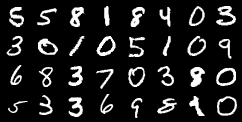

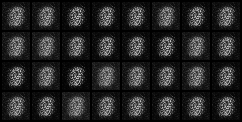

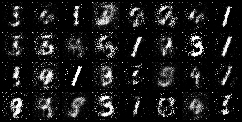

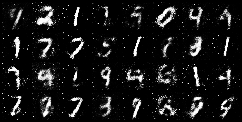

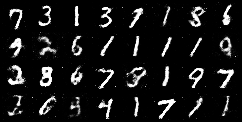

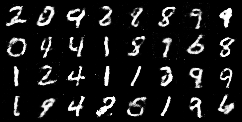